<a href="https://colab.research.google.com/github/iamemc/PD_02/blob/main/PD03_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining / Prospecção de Dados

## Diogo F. Soares and Sara C. Madeira, 2020/21

# Project 2 - Clustering

## Logistics 

**_Read Carefully_**

**Students should work in teams of 2 or 3 people**. 

Individual projects might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `April, 18th (23:59)`.** 

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the zip file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202021_P2.ipynb`as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs** (File > Download as > HTML).

**Decisions should be justified and results should be critically discussed.** 

_Project solutions containing only code and outputs without discussions will achieve a maximum grade 10 out of 20._

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/)**.

The dataset to be analysed is **`medulloblastoma_genes.csv`**. It includes 76 samples of medulloblastoma (MB) with respective expression levels of 54.675 genes measured in children with ages between 3 and 16 years. Medulloblastoma is a malignant childhood brain tumour comprising four discrete subgroups. 

In this project you will consider the labels of the samples included in the `labels.csv` file where samples are labelled as MB-CL or Other. In this case, we have 51 samples of classic medulloblastoma (MB-CL) and 25 other types (namely: 6 desmoplastic nodular, 17 anaplastic and 2 medullomyoblastoma).

In `medulloblastoma_genes.csv` each line represents a sample and each column represents a gene.


**The goal is to cluster samples and (ideally) find "MB-CL" groups and "Other MB" groups.** 

## Team Identification

**GROUP PD03**

Students:

* **Eduardo Carvalho - nº55881**
* **Filipe Santos - nº55142**
* **Ivo Oliveira - nº50301**

## 1. Load and Preprocess Dataset

At the end of this step you should have:
* a 76 rows × 54675 columns matrix, **X**, containing the values of the 54675 features for each of the 76 samples.
* a vector, **y**, with the 76 type of medulloblastoma, which you can use later to evaluate clustering quality.

### Importing relevant libraries

In [1]:
from pandas import read_csv, DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import cluster
from sklearn.metrics.cluster import calinski_harabasz_score

### Importing the datasets

In [2]:
X=read_csv('/content/medulloblastoma_genes.csv', index_col=0)
X.shape

(76, 54675)

In [3]:
X.head(3)

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552258_at,1552261_at,1552263_at,1552264_a_at,1552266_at,1552269_at,1552271_at,1552272_a_at,1552274_at,1552275_s_at,1552276_a_at,1552277_a_at,1552278_a_at,1552279_a_at,1552280_at,1552281_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552293_at,1552295_a_at,1552296_at,...,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-hum_alu_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM918578,7.59594,6.14440,4.82431,5.67092,4.14155,5.48935,6.01078,5.17671,4.83708,4.77996,3.42752,6.03596,5.21494,6.03596,6.31192,4.79744,4.88884,4.92362,5.93357,3.41773,3.61899,3.40784,3.79099,7.13106,6.52605,4.49647,6.31771,4.52070,6.31861,4.29729,4.14946,5.07455,5.00395,6.86808,3.36730,4.35799,6.42487,3.66612,5.80724,4.30946,...,7.36941,9.31655,8.55281,11.6420,6.67064,5.54635,5.82718,5.13521,8.45163,8.64319,5.99121,6.00857,6.30792,8.43453,8.10077,8.17662,5.93410,5.98444,5.68256,6.71901,6.84215,6.21441,7.29227,6.87863,6.85667,7.72991,7.93229,7.97543,8.78430,8.64773,10.2364,10.1202,11.5560,11.2308,6.94803,6.42487,6.70991,4.48639,4.43082,3.48738
GSM918579,7.80665,6.19154,5.24439,5.62149,3.41773,5.70478,5.98896,3.45316,4.34121,4.28772,3.65066,6.71732,5.21927,5.81622,6.86537,5.44760,5.02913,5.03565,5.32885,4.34251,3.60550,4.55913,5.23750,6.03644,3.62966,4.99991,6.06773,5.29782,5.81532,3.62434,5.00193,4.88280,5.86391,7.56034,4.58701,5.15560,6.29397,3.54385,5.58837,4.51634,...,8.40349,8.21690,8.62825,11.6876,6.40506,3.24259,4.51415,3.77735,8.79546,7.61923,5.42539,4.08598,4.08598,7.78589,3.19048,6.33204,5.52744,4.12552,4.93807,6.28320,4.14946,4.70139,6.25652,4.37952,4.70048,7.83257,8.51571,8.16721,9.16005,9.14255,10.4747,10.4893,11.6799,11.3475,6.09785,4.38328,4.68583,3.40120,4.20916,4.40915
GSM918580,7.60080,5.97406,5.36270,5.78598,3.32863,6.13340,6.09108,3.63495,5.12218,4.75875,3.62167,5.83247,5.27556,6.73875,6.84800,4.83071,5.34949,5.14458,5.01263,5.17445,3.18635,3.72569,5.51302,5.25489,5.40268,4.08598,6.13144,5.73722,6.00241,3.79773,5.59211,6.16395,6.77992,7.13130,4.17746,5.51826,6.96414,4.63376,6.01567,4.63861,...,8.51057,8.08024,8.62006,11.8940,6.83604,4.67470,4.92362,3.72328,10.25130,8.65130,5.88444,3.37074,4.16044,8.09071,3.19048,6.20799,5.65073,4.84261,4.87137,6.00018,4.72739,3.58074,6.83098,4.20767,4.80484,8.25546,8.92078,8.39658,9.45981,9.42748,10.8532,10.7125,11.9298,11.6038,6.49375,3.24259,3.91999,3.13114,4.02892,4.93087


> X is a dataset with 76 rows and close to 54675 (!) features.
>
> Sample numbers are the dataset's index and the genes its features.
>
> At first glance, its values seem to be in the same range (between 0 and 10), which might indicate there are big differences in scale. We will, however, scale the dataset in a future step to prevent scaling issues.

In [4]:
y=read_csv('/content/labels.csv', index_col=0)
y.shape

(76, 1)

In [5]:
y.head(3)

,class
samples,
GSM918578,MB-CL
GSM918579,MB-CL
GSM918580,MB-CL


In [6]:
y['class'].value_counts()

MB-CL    51
Other    25
Name: class, dtype: int64

> y is a dataset with 76 rows and a single column.
>
> Like X, the samples are the rows and the column represents the true class to which each sample belongs.
>
> We can also confirm that there are only 2 classes in the dataset - 'MB-CL' and 'Other' - with a proportion of 2:1 in favor of the class 'MB-CL'.

## 2. Dimensionality Reduction

As you already noticed the number of features (genes) is extremely high when compared to the number of objects to cluster (samples). In this context, you should perform dimensionality reduction, that is, reduce the number of features, in two ways:

* [**Removing features with low variance**](http://scikit-learn.org/stable/modules/feature_selection.html)

* [**Using Principal Component Analysis**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

At the end of this step you should have two new matrices with the same number of rows, each with a different number of columns (features): **X_variance** and **X_PCA**. 

**Don't change X you will need it!**

### Removing features with low variance

> We will start by using VarianceThreshold with threshold=0. This creates an array with the variance values for every one of the 54675 features of the dataset.
>
> We will also standardize the dataset using MinMaxScaler to reduce the impact of the scale of the data in the variance. It is interesting to note that using StandardScaler instead would convert all the variances in the dataset to 1 and destroy the utility of the variance values for dimensionality reduction.

In [7]:
# creating a VarianceThreshold object with threshold=0
var_thresh = VarianceThreshold(threshold=0)

# standardizing the data
std_X = MinMaxScaler().fit_transform(X)

# fitting the object to the standardized dataset
var_thresh.fit(std_X)

# creating a dataframe containing the variances for all the features in the dataset
df_var=DataFrame(var_thresh.variances_, columns=['Variance'])\
                .sort_values(by='Variance', ascending=False)
df_var.head()

,Variance
4657,0.135650
14447,0.134134
33847,0.128592
16070,0.125255
40664,0.123512


> The variance values are already ordered from highest to lowest. We can see that the highest 5 values range from 0.1356 to 0.1235.
> We will now plot all of these values to better understand how the variance varies across the standardized dataset.

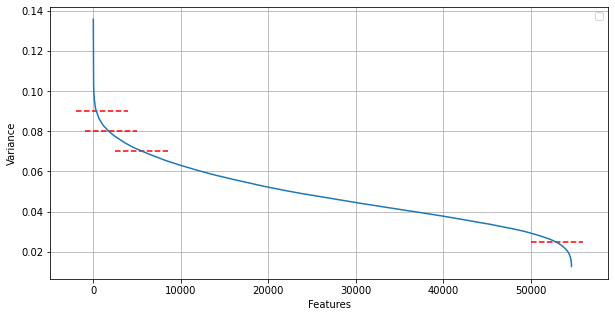

In [8]:
# plotting the variances in df_var
# we need to reset the index for the plot to make sense
plt.figure(figsize=(10, 5))
plt.plot(df_var.reset_index(drop=True))
plt.hlines(0.09, -2000, 4000, colors='red', linestyles='--')
plt.hlines(0.08, -1000, 5000, colors='red', linestyles='--')
plt.hlines(0.07, 2500, 8500, colors='red', linestyles='--')
plt.hlines(0.025, 50000, 56000, colors='red', linestyles='--')
plt.grid(True)
plt.xlabel('Features')
plt.ylabel('Variance');
plt.legend('')
plt.show()

> We can see the variance for most of the features is smaller than 0.06. 
>
> We can also identify variance=0.08 as the point where the values start to stabilize.
>
> For this reason, we will keep all features that have variance higher than 0.09. Doing this will be a considerable drop in the number of features. 
>
> We could have opted for a lower value as the threshold, like 0.8 or 0.7, as they also belong to the region where the variance starts to stabilize for the first time.
>
> We could also choose an even lower value, like 0.025, for which there is another stabilization in the variance values. However, this would still leaves us with over 50 thousand features.
>
> So, we will create a new VarianceThreshold object with threshold=0.09, fit it to the standardized dataset and see how many features we are left with.

In [9]:
# creating a new VarianceThreshold object with threshold=1
vt = VarianceThreshold(threshold=0.09)

# fitting the dataset
vt.fit(std_X)

# get_support is an array with True/False values
# True values identify features with variance > 1
mask = vt.get_support()

# we can use mask to subset the original dataset and create X_variance
# X_variance contains only features with variance > 1
X_variance = X.loc[:, mask]

# checking the difference in feature number between X and X_variance
print('Features in X:', X.shape[1])
print('Features in X_variance:', X_variance.shape[1])
print('Difference in number of features:', X.shape[1]-X_variance.shape[1])

Features in X: 54675
Features in X_variance: 349
Difference in number of features: 54326


> By defining the cut-off point for variance as 0.09 we were able to reduce the number of features in the dataset from 54675 to 349.
>
> This means we eliminated 54326 features that had low variance and, as such, were not good enough to differentiate the genes between the two classes in study.

### Using Principal Components Analysis

> Before applying PCA to the dataset we need to standardize its values. This time we use StandardScaler as we want to negate the impact of high-variance features in PCA.

In [10]:
# Standardizing the features
std_X_2 = StandardScaler().fit_transform(X)

> To define the number of components to be used we will follow the same process we employed to X_variance.
>
> We will start with a PCA object with n_components=None that includes all of the components for the dataset and use it to figure out the ideal number of components.

In [11]:
# creating a PCA object with n_components=None
pca = PCA()

# fitting PCA to the standardized dataset
pca.fit(std_X_2)

# checking the total number of components
pca.n_components_

76

> We can see that, after applying PCA to the standardized dataset, we were left with 76 components.
>
> We can further reduce this number by selecting only the components that explain a high percentage of the total variance of the dataset.
>
> For that reason, we will plot the cumulative sum of the explained variance of pca, after fitting std_X_2.

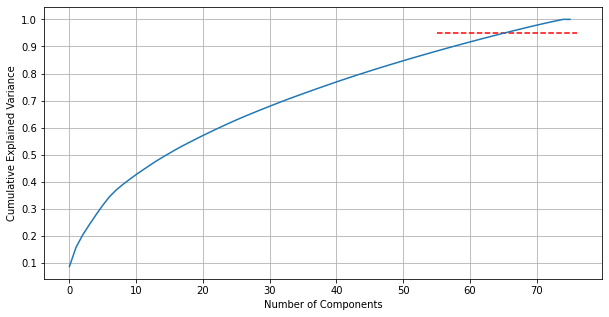

In [12]:
# creating a plot for the cumulative sum of explained variance in std_X
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.linspace(0.1, 1, 10))
plt.hlines(y=0.95, xmin=55, xmax=76, colors='red', linestyles='--')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

> In this graph we see the cumulative sum of explained variance for all components. The components are ordered by decreasing value of explained variance and has a max value of 1 (the total variance in the dataset).
>
> We can choose a value of explained variance that we think is "good enough" to represent the total dataset and identify the number of components that we need to keep to achieve it.
>
> For example, if we defined the threshold as 70% (0.7) we can see that we would need to keep at least 35 components.
>
> Most of the components have similar explained variance values as evidenced by the lack of a pronounced curve in the plot. The only curve we can identify is between 5 and 10 components. However, this number of components only accounts for about 35% of all variance, a very low number.
>
> In this case, we will define the threshold as 95%, as this is allows for a high value of explained variance while reducing some of the less important components. 
>
> We can see that 0.95 is reached between 60 and 70, which means we will be left with a high number of components. However, this also means we can cut close to 10 components from the total number.
>
> We will again apply PCA to the standardized dataset but, this time, we will define the number of components as the percentage of explained variance that we defined before (0.95).

In [13]:
# creating a PCA object with only the components needed to achieve 95% explained variance
pca = PCA(n_components=0.95)

# fitting the object to the standardized dataset
pca.fit(std_X_2)

# creating a new dataframe X_PCA that contains the number of components needed to meet the threshold
X_PCA = pca.transform(std_X_2)

# checking the difference in number of features in X and X_PCA
print('Features in X:', X.shape[1])
print('Features in X_PCA:', len(X_PCA[0]))
print('Difference in number of features:', X.shape[1]-len(X_PCA[0]))

Features in X: 54675
Features in X_PCA: 67
Difference in number of features: 54608


> After PCA, we are now left with an object with (only) 67 features, a much smaller number of features than the 54675 in the original dataset, representing a decrease in more than 54 thousand features.

> After all of this preprocessing, we end up with 3 different datasets: X, X_variance and X_PCA. We also have all the true labels for the samples in the dataset y.

In [14]:
print('X has', X.shape[0], 'rows and', X.shape[1], 'features.')
print('X_variance has', X_variance.shape[0], 'rows and', X_variance.shape[1], 'features.')
print('X_PCA has', X_PCA.shape[0], 'rows and', X_PCA.shape[1], 'features.')
print('y has', y.shape[0], 'rows and', y['class'].nunique(), 'different labels.')

X has 76 rows and 54675 features.
X_variance has 76 rows and 349 features.
X_PCA has 76 rows and 67 features.
y has 76 rows and 2 different labels.


## 3. Clustering Samples using Partitional Clustering

Use **`K`-means** to cluster the samples:

* Cluster the original data (54.675 features): **X**.
    * Use different values of `K`.
    * For each value of `K` present the clustering by specifying how many samples MB-CL and Other are in each cluster.     
    For instance, `{0: {'MB-CL': 51, 'Other': 0}, 1: {'MB-CL': 0, 'Other': 25}}` is the ideal clustering that we aimed at obtained with K-means when `K=2`, where the first cluster has 51 MB-CL samples and 0 Other samples and the second cluster has 0 MB-CL samples and 25 Other samples.
    You can choose how to output this information.  **Tip**: You can explore the usage of contigency matrices.
    * What is the best value of `K` ? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data obtained after removing features with low variance: **X_variance**.
    * Study different values of `K` as above.

* Cluster the data obtained after applying PCA: **X_PCA**.
    * Study different values of `K` as above.

* Compare the results obtained in the three datasets above for the best `K`. 
* Discuss the results.

## K-Means - X

> We will start by running K-Means on the original dataset with all 54675 features. This will provide a baseline to which we can compare the results from X_variance and X_PCA.

### Running k-means for different values of k

> By K-Means for values of k between 2 and 10 we are able to see how this variation impacts the distribution of samples between clusters.
>
> We will also create contingency matrices to compare the clustering results with the true labels and evaluate how good the performance of K-Means is. 
>
> Ideally, we want the clusters to contain only samples from one of the two classes of medulloblastoma.

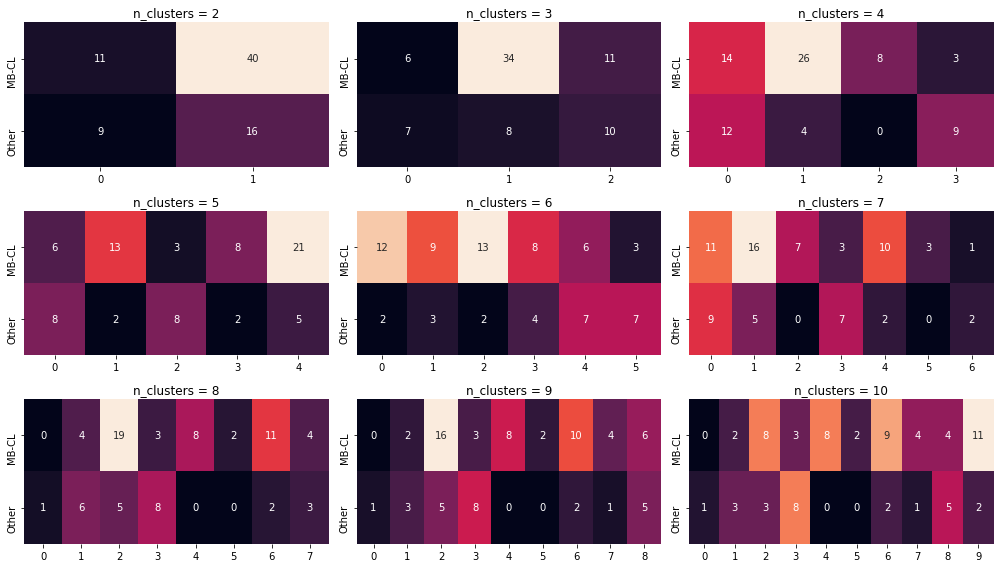

In [15]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> The contingency matrices show how many samples from which class are in each cluster. For example, when k=2, we have 11 samples of class 'MB-CL' and 9 samples of class 'Other' in cluster 0 and 40 samples of class 'MB-CL' and 16 of class 'Other' in cluster 1.
>
> We can already see that there is no k value for which we have the ideal scenario of having the classes perfectly separated.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL' which might be related to the proportion of the classes in the dataset (the number of samples with class 'MB-CL' is double the number of samples from class 'Other').
>
> The first cluster which is composed only of samples from class 'MB-CL' appears when k=4. The first cluster which is composed only of samples from class 'Other' appears when k=8.
>
> While the contingency matrices are a good way to visualize the samples' separation in clusters we need a hard metric that can indicate how well that separation is being done. For that reason, we can resort to the Silhouette score.

### Determining ideal number of clusters by Silhouette Score

> We can use the silhouette score to evaluate the quality of the clusters created after aplying K-Means in terms of how well samples are clustered with other samples that are similar to each other. 
>
> This score varies between -1 and 1.  A score of 1 that the cluster is dense and well-separated than other clusters. A value close to 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score indicates that the samples might have got assigned to the wrong clusters.
>
> By using silhouette_score we obtain the average Silhouette score for a certain k.
>
> We will calculate this value for n_clusters between 2 and 10, storing the values in a list and plotting them, for an easier analysis.

for n_clusters = 2 the silhouette score is 0.103.
for n_clusters = 3 the silhouette score is 0.079.
for n_clusters = 4 the silhouette score is 0.085.
for n_clusters = 5 the silhouette score is 0.079.
for n_clusters = 6 the silhouette score is 0.054.
for n_clusters = 7 the silhouette score is 0.076.
for n_clusters = 8 the silhouette score is 0.073.
for n_clusters = 9 the silhouette score is 0.072.
for n_clusters = 10 the silhouette score is 0.059.




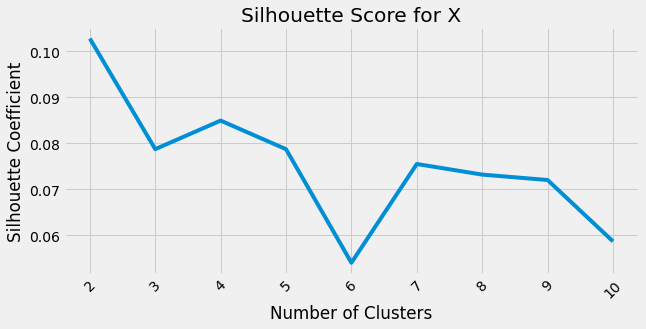

In [16]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the original dataset
  kmeans.fit(X)
  # calculating the silhouette score 
  score = silhouette_score(X, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhouette score is', str(round(score, 3)) + '.')

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> Looking at the plot obtained we can see that there is a decreasing trend as the value for n_clusters increases.
>
> There are only 2 increases in score, for n_clusters=4 and n_clusters=7.
>
> As we have seen before, the best value for the silhouette score is the one that is closest to 1. With that in mind, the best number of clusters is 2 - where the average silhouette score is the highest (0.103).
>
> However, as we saw before, the samples are not correctly separated between clusters. And, despite being the highest value, the silhouette score is also very close to 0, which means it is actually not a good result.
>
> Now that we know the average score for each value of k, we can look at the silhouette score for each cluster that is defined. For that purpose, we will use a function that was provided by the Teacher in TP08 and that allows us to graphically represent the Silhuette Scores (SC) per n_cluster=i and its total average.


In [17]:
# defining silhouette plot function from TP08
def draw_silhouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(8,6))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

> For a k value to be considered as "good" we want to see 3 things:
> + 1. a high average score (as we saw before, it is highest when k=2);
> + 2. the plot for each cluster should be above the average as much as possible (over the dashed line) and values below 0 should be avoided;
> + 3. the clusters should be evenly distributed in number of samples (there should be no cluster where the overwhelming majority of samples are).
>
> With that in mind let's plot the graph for k=2.

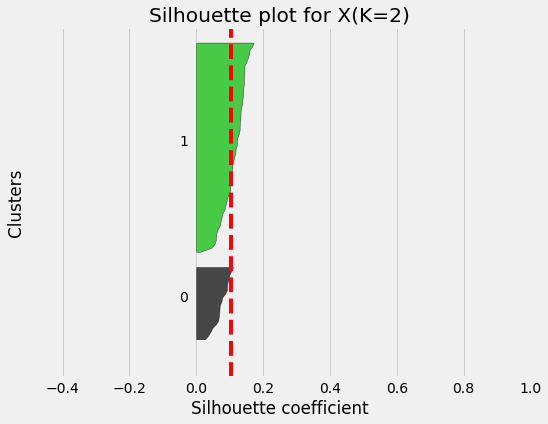

In [18]:
k=2
kmeans_X = KMeans(n_clusters=k, random_state=0)
kmeans_X = kmeans_X.fit(X) 

# draw silhouette plot
draw_silhouette(X, kmeans_X.labels_, "for X(K="+str(k)+")")

> Although there are no values below 0, we can see that there is no balance between clusters, with cluster 1 being more than the triple of cluster 0.
>
> We should look at other values of k that might be better distributed. We will look at k=3, 4 and 5, the other values for which k is highest.

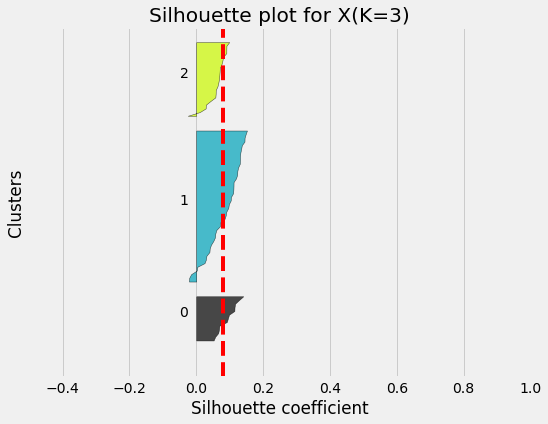

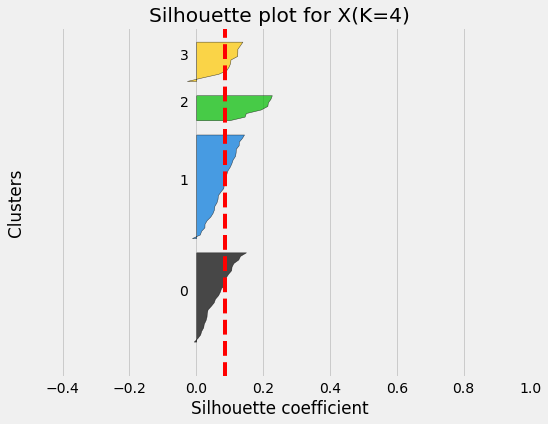

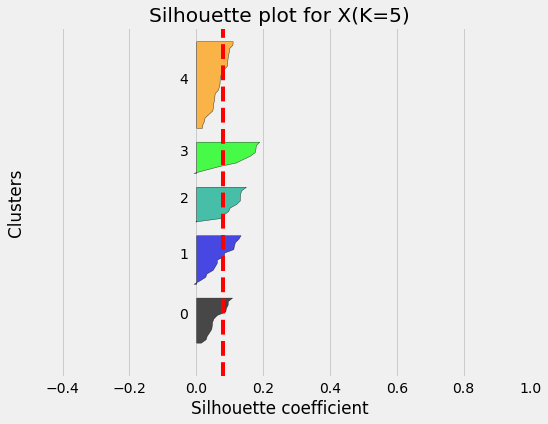

In [19]:
for k in range(3,6):
  kmeans_X = KMeans(n_clusters=k, random_state=0)
  kmeans_X = kmeans_X.fit(X) 

  # draw silhouette plot
  draw_silhouette(X, kmeans_X.labels_, "for X(K="+str(k)+")")
  plt.show()

> By looking at the graphs above, we can see that, for k=5, there is a better distribution among the clusters, all clusters have considerable portion above the average line and only a tiny portion below 0.
>
> For these reasons, 5 seems to be the best value of k when it comes to the original dataset, even though the average silhouette score is lower than k=2.

for n_clusters = 5 the silhouette score is 0.079.



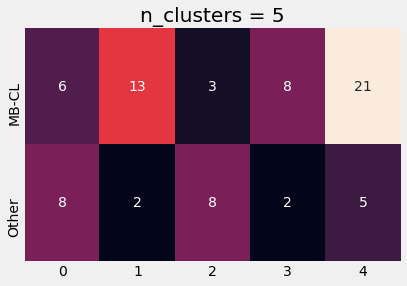

In [20]:
# Final kmeans for X and contingency matrix
kmeans_X = KMeans(n_clusters=5, random_state=0)
kmeans_X = kmeans_X.fit(X) 

# silhouette score for X, n_clusters=5
score_X = silhouette_score(X, kmeans_X.labels_)
print('for n_clusters = 5 the silhouette score is', str(round(score_X, 3)) + '.\n')

# contingency matrix for X, n_clusters=5
cm_X=contingency_matrix(y['class'], kmeans_X.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 5')
plt.show()

## K-means - X_variance

> For the dataset with only high-variance features we will adopt the same process as before and start by plotting the contingency matrices from k=2 to k=10.

### Running k-means for different values of k

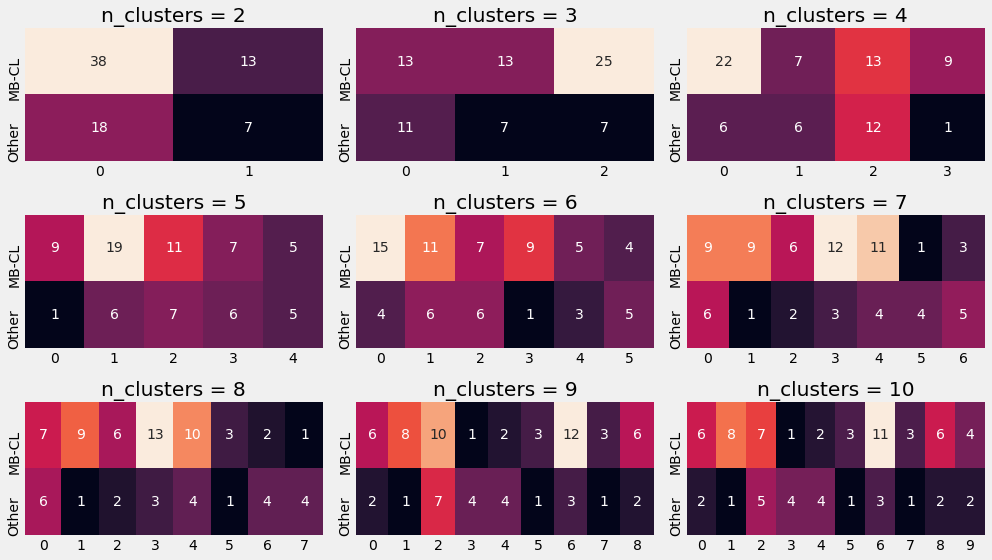

In [21]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X_variance)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X_var=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X_var, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Like we saw in the matrices for X, there is no k value for which we have the ideal scenario of having the classes perfectly separated, when we use the high-variance dataset.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL', as we have seen before.
>
> Unlike the previous case, there are no cluster comprised entirely of samples from the same class. The cluster with the biggest difference in classes appears when k=4 (cluster 3). The first predominantly 'Other' cluster appear when k=6.
>
> Like we did before, we will calculate the silhouette scores for each k value, to identify the case when the clusters are better separated.

### Determining ideal number of clusters by Silhouette Score

for n_clusters = 2 the silhoette score is 0.197
for n_clusters = 3 the silhoette score is 0.138
for n_clusters = 4 the silhoette score is 0.142
for n_clusters = 5 the silhoette score is 0.139
for n_clusters = 6 the silhoette score is 0.113
for n_clusters = 7 the silhoette score is 0.098
for n_clusters = 8 the silhoette score is 0.096
for n_clusters = 9 the silhoette score is 0.081
for n_clusters = 10 the silhoette score is 0.083




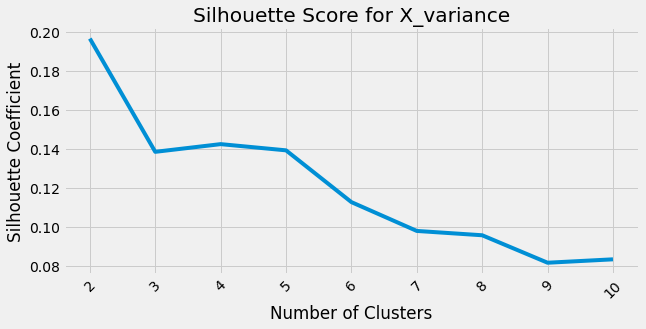

In [22]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the dataset with only high-variance features
  kmeans.fit(X_variance)
  # calculating the silhouette score 
  score = silhouette_score(X_variance, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhoette score is', round(score, 3))

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X_variance')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> As we saw in the previous case, the plot shows a decreasing trend in the silhouette score as the number of clusters increases.
> 
> There are, however, 3 small increases in the score (n_clusters = 4, 9 and 10).
>
> Like in the previous case, the silhouette score is highest when n_clusters = 2, with a value of 0.197. 
>
> Despite being almost double the value of the silhouette score for X and n_clusters=2, this is still a very low value meaning that the clusters are not very well separated from each other.

> Like we did before, we will now build the silhouette plot for k=2 and see if this value of k meets all the criteria we mentioned before.

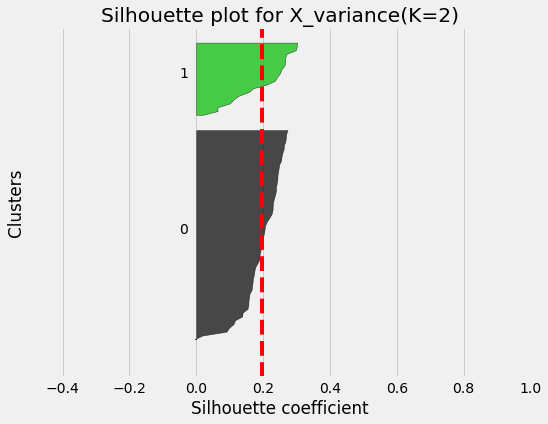

In [23]:
k=2
kmeans_var = KMeans(n_clusters=k, random_state=0)
kmeans_var = kmeans_var.fit(X_variance) 

# draw silhouette plot
draw_silhouette(X_variance, kmeans_var.labels_, "for X_variance(K="+str(k)+")")

> Yet again we see that the samples are not well distributed between clusters, with cluster 0 comprising the vast majority.
>
> We can look at 3, 4 and 5 as values for k, the values that show the next highest average score.

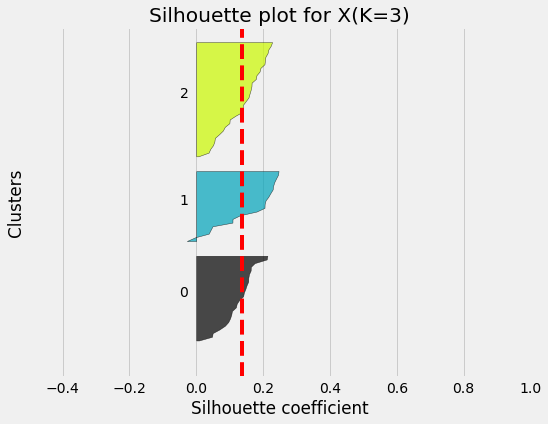

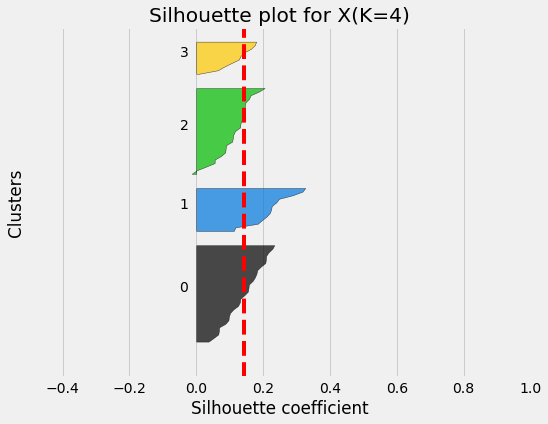

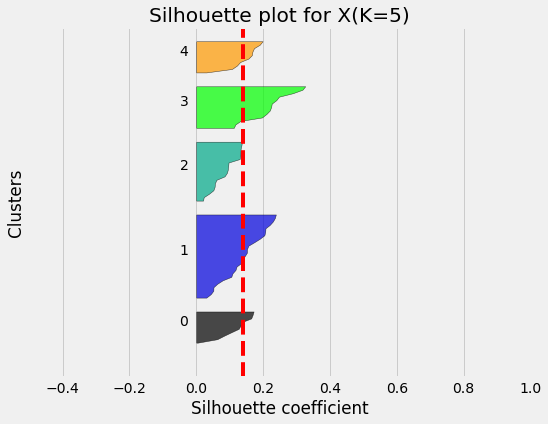

In [24]:
for k in range(3,6):
  kmeans_var = KMeans(n_clusters=k, random_state=0)
  kmeans_var = kmeans_var.fit(X_variance) 

  # draw silhouette plot
  draw_silhouette(X_variance, kmeans_var.labels_, "for X(K="+str(k)+")")
  plt.show()

> k=3 seems to be where the clusters are better distributed, all clusters have regions above the average score and there is only a small portion of cluster 1 that is below 0. Its average silhouette score is still 0.138, which is lower than for k=2 but still one of the highest values.
>
> For these reasons, 3 seems to be the best value of k for X_variance.

for n_clusters = 3 the silhouette score is 0.138.



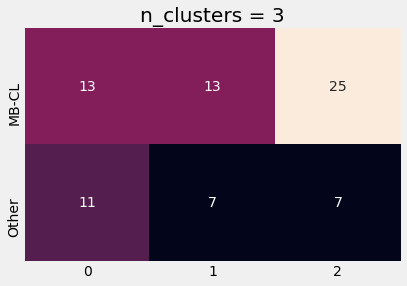

In [25]:
# Final kmeans for X_variance
kmeans_var = KMeans(n_clusters=3, random_state=0)
kmeans_var = kmeans_var.fit(X_variance) 

# silhouette score for X_variance, n_clusters=3
score_var = silhouette_score(X_variance, kmeans_var.labels_)
print('for n_clusters = 3 the silhouette score is', str(round(score_var, 3)) + '.\n')

# contingency matrix for X_variance, n_clusters=3
cm_var=contingency_matrix(y['class'], kmeans_var.labels_)
sn.heatmap(cm_var, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 3')
plt.show()

## K-means - X_PCA

> Again, we will start by applying K-Means to the dataset after applying PCA, with k values ranging from 2 to 10.

### Running k-means for different values of k

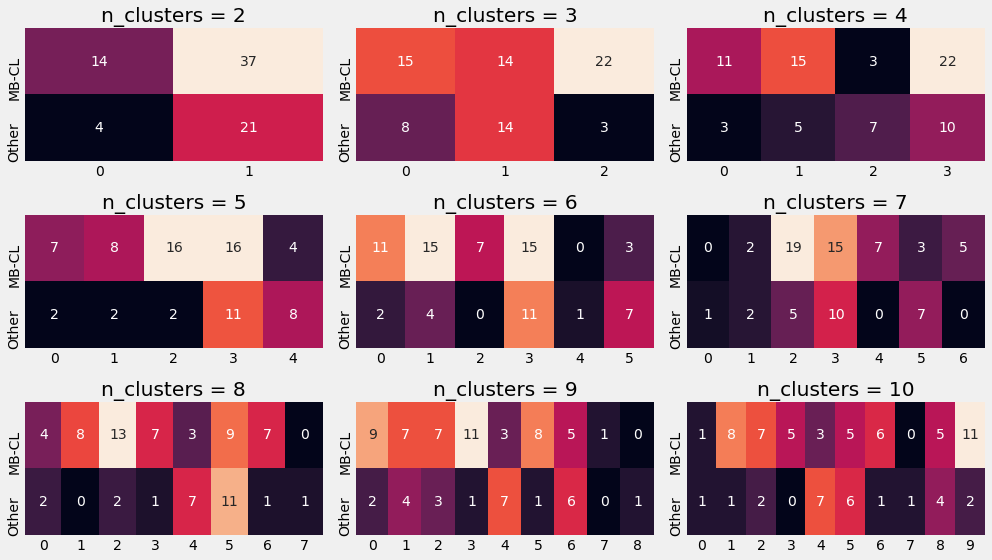

In [26]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X_PCA)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X_PCA=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X_PCA, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Like we saw in the matrices for X, there is no k value for which we have the ideal scenario of having the classes perfectly separated, when we use the high-variance dataset.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL', as we have seen before. However, in this case, the first predominantly 'Other' cluster appears when k=4 (cluster 2), earlier than in previous steps.
>
> There are also clusters where all the samples belong to the same class. When k=6, cluster 2 has only 'MB-CL' samples while cluster 4 is composed of a single sample from class 'Other'.
>
> We will, again, calculate the silhouette scores for each k value to identify the best k and to be able to compare this clustering to the others presented before.

### Determining ideal number of clusters by Silhouette Score

for n_clusters = 2 the silhouette score is 0.089
for n_clusters = 3 the silhouette score is 0.034
for n_clusters = 4 the silhouette score is 0.035
for n_clusters = 5 the silhouette score is 0.036
for n_clusters = 6 the silhouette score is 0.045
for n_clusters = 7 the silhouette score is 0.049
for n_clusters = 8 the silhouette score is 0.033
for n_clusters = 9 the silhouette score is 0.017
for n_clusters = 10 the silhouette score is 0.021




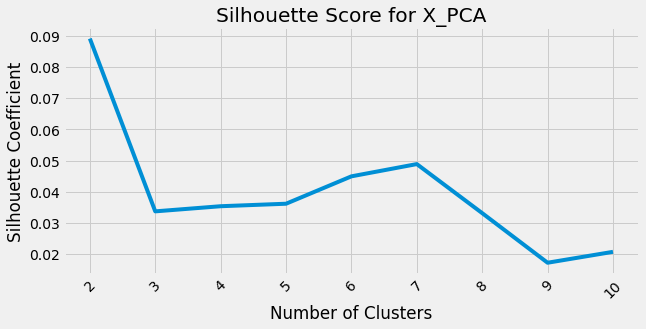

In [27]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the dataset after applying PCA and 95% explained variance
  kmeans.fit(X_PCA)
  # calculating the silhouette score 
  score = silhouette_score(X_PCA, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhouette score is', round(score, 3))

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X_PCA')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> Once again we see a decrease in silhouette score with the increase of n_clusters.
>
> There are, however, 5 increases in score (n_clusters = 4, 5, 6, 7 and 10).
>
>
> The highest silhouette score is, once again, for n_clusters=2, with a value of 0.089. This is very close to 0 and, as we have seen before, it means that the clusters are not well separated from each other.

> We will now build a silhouette plot for k=2 to evaluate the criteria mentioned above.

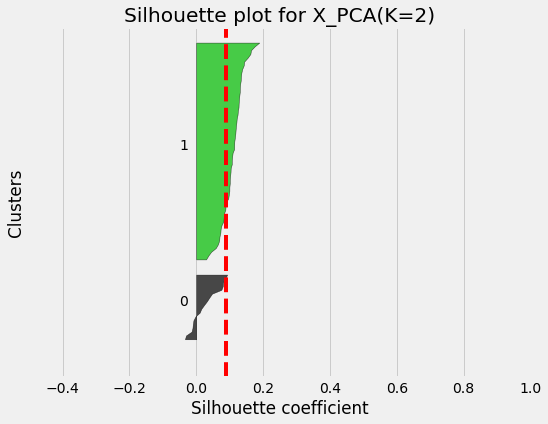

In [28]:
k=2
kmeans_PCA = KMeans(n_clusters=k, random_state=0)
kmeans_PCA = kmeans_PCA.fit(X_PCA) 

# draw silhouette plot
draw_silhouette(X_PCA, kmeans_PCA.labels_, "for X_PCA(K="+str(k)+")")

> The clusters for X_PCA are even worse than the ones from the previous datasets, in terms of balance and scores (cluster 0 barely meets the average score and shows a significant portion below 0).
>
> This time we will look at values of k between 3 and 7, as there seems to be an increase in the average score for values between 5 and 7.

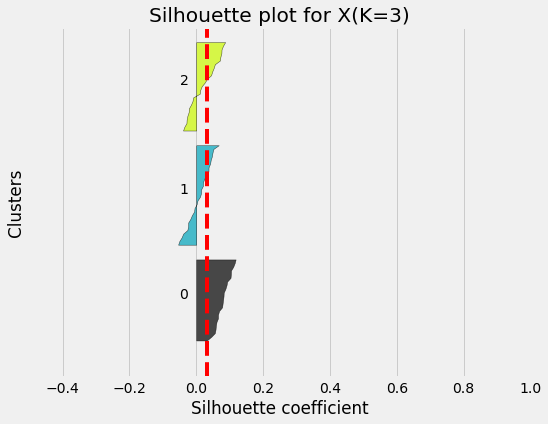

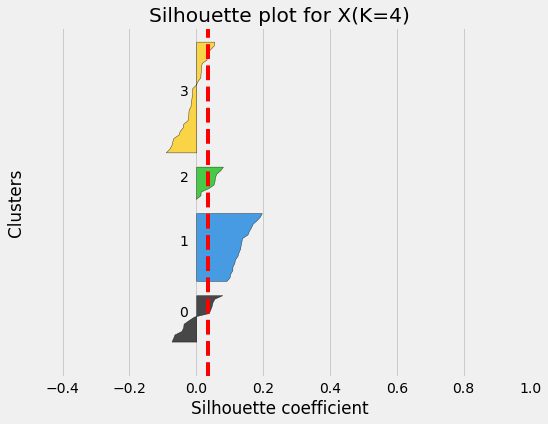

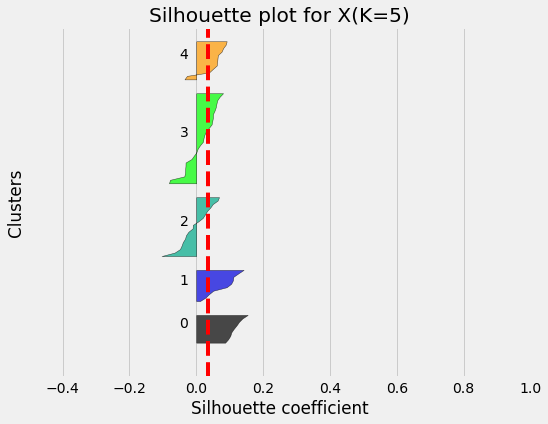

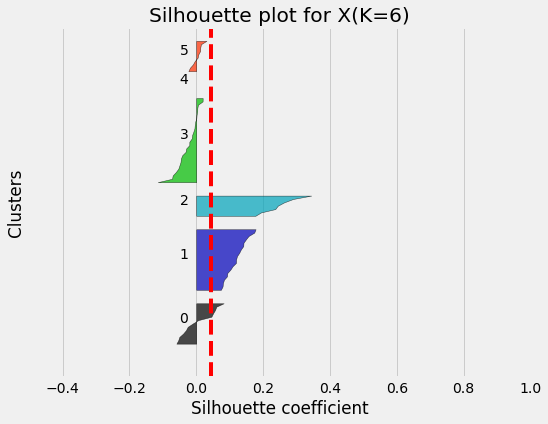

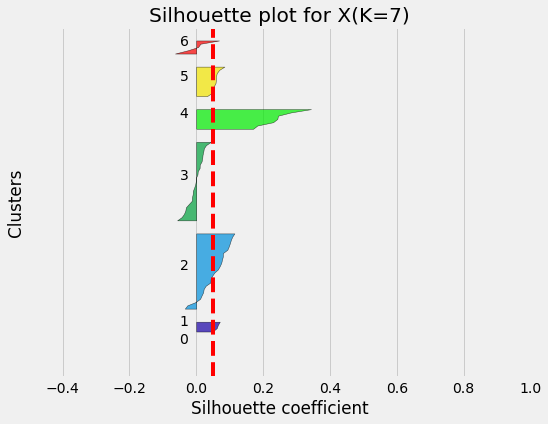

In [29]:
for k in range(3,8):
  kmeans_PCA = KMeans(n_clusters=k, random_state=0)
  kmeans_PCA = kmeans_PCA.fit(X_PCA) 

  # draw silhouette plot
  draw_silhouette(X_PCA, kmeans_PCA.labels_, "for X(K="+str(k)+")")
  plt.show()

> In this case, the silhouette plots are very bad, with all of them showing balance and score issues. The plot for k=3 seems to be the less bad, as the clusters are balanced in width and all above the average score (even though it is the lowest for all the k values considered). However, clusters 1 and 2 have considerable portions below 0.
>
> We will choose k=3 as the best for the dataset after applying PCA.

for n_clusters = 3 the silhouette score is 0.034.



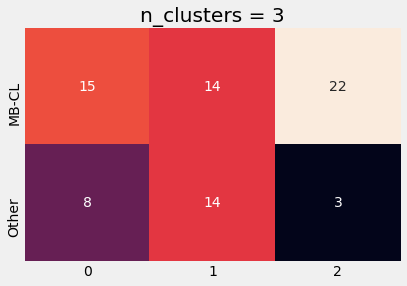

In [30]:
# Final k-means with n_clusters=3
kmeans_PCA = KMeans(n_clusters=3, random_state=0)
kmeans_PCA = kmeans_PCA.fit(X_PCA) 

# silhouette score for X_PCA, n_clusters=3
score_PCA = silhouette_score(X_PCA, kmeans_PCA.labels_)
print('for n_clusters = 3 the silhouette score is', str(round(score_PCA, 3)) + '.\n')

# contingency matrix for X_PCA, n_clusters=3
cm_PCA=contingency_matrix(y['class'], kmeans_PCA.labels_)
sn.heatmap(cm_PCA, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 3')
plt.show()

## Comparison of Results and Discussion

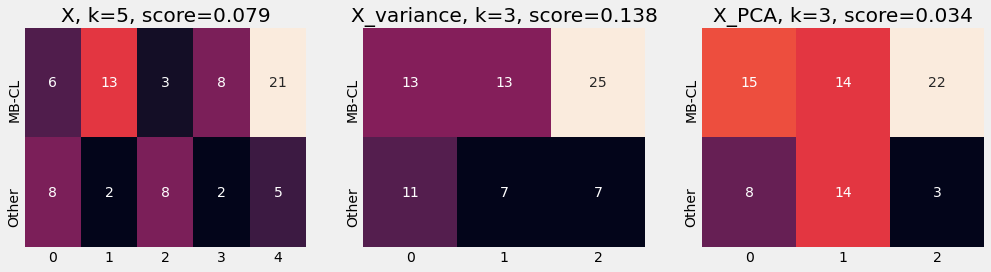

In [31]:
# defining rows and cols for the plot grid
rows=1
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,4))

# X
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[0])
axes[0].set_title('X, k=5, score='+str(round(score_X, 3)))

# X_variance
sn.heatmap(cm_var, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[1])
axes[1].set_title('X_variance, k=3, score='+str(round(score_var, 3)))

# X_PCA
sn.heatmap(cm_PCA, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[2])
axes[2].set_title('X_PCA, k=3, score='+str(round(score_PCA, 3)))

fig.tight_layout()
plt.show()

> We can now compare the results obtained for X, X_variance and X_PCA. For X the best value of k is 5 while for X_variance and X_PCA it's 3.
>
> For all datasets we can identify the best distributed cluster in terms of true sample labels:
> + X - cluster 4 has 21 'MB-CL' samples and only 5 'Other';
> + X_variance - cluster 2 has 25 'MB-CL' samples and only 7 'Other';
> + X_PCA - cluster 2 has 22 'MB-CL' samples and only 3 'Other'.
>
> When it comes to the average silhouette score, the highest is for X_variance (0.138), a score that is almost double the score of X (0.079), the second highest value. X_PCA has the lowest score (0.034).
>
> Even though it has the lowest average score, X_PCA has the best divided cluster, when it comes to the true sample labels.
>
> All of these results are heavily influenced by the choices taken in the preprocessing steps, namely the definition of thresholds for X_variance and X_PCA. That would be an interesting experiment to conduct, to get the silhouette_scores for varying values of each threshold to try to acess its impact in the final results.
>
> However, with the parameters we used, we conclude that the clustering of X_variance using K-Means is better than the other two, as it shows the highest silhouette score and displays an acceptable separation between the classes in study.

## 4. Clustering Samples using Hierarchical Clustering

Use a **Hierarchical Clustering Algorithm (HCA)** to cluster the samples: 

* Cluster the data in **X_variance**.
    * Use **different linkage metrics**.
    * Use different values of `K`.
    * For each linkage metric and value of `K` present the clustering by specifying how many MB-CL and Other samples are in each cluster as you did before. 
    * What is the best linkage metric and the best value of `K`? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data in **X_PCA**.
    * Study different linkage metrics and different values of `K` as above.

* Compare the results obtained in the two datasets above for the best linkage metric and the best `K`. 
* Discuss the results

## 4. Clustering using Hierarchical Clustering - X_variance data

### Silhoutte Score for various linkage metrics -X_variance

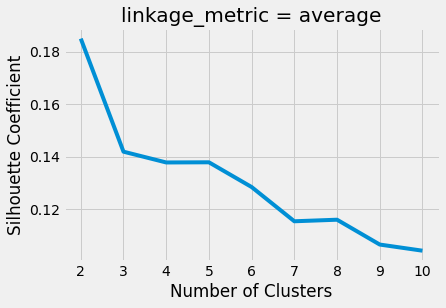

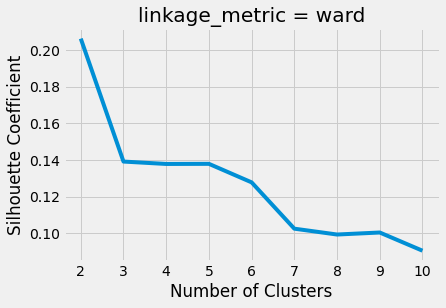

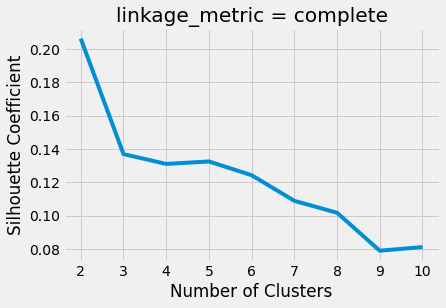

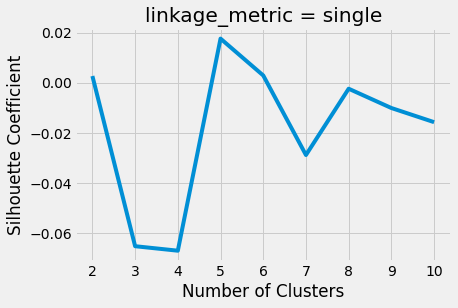

In [32]:
linkage= ["average","ward","complete","single"]#list with all linkage metrics
for j in linkage:
  #silhouette scores results for every metric
  silhouette_coefficients = []
  for i in range(2, 11): # from n_cluster =2 to =10
    hca = AgglomerativeClustering(linkage =j, n_clusters=i)
    hca = hca.fit(X_variance)
    score = silhouette_score(X_variance, hca.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, 11), silhouette_coefficients)
  plt.title('linkage_metric = ' + str(j))
  plt.xticks(range(2, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

With average, ward, complete and single linkage:
> There is a maximum silhoutte coeficcient with #clusters = 2 

With single linkage:
> There is also a local maximum at #clusters = 5

### Contingency Matrixes per linkage metric with multiple Nºclusters




#### Average Linkage

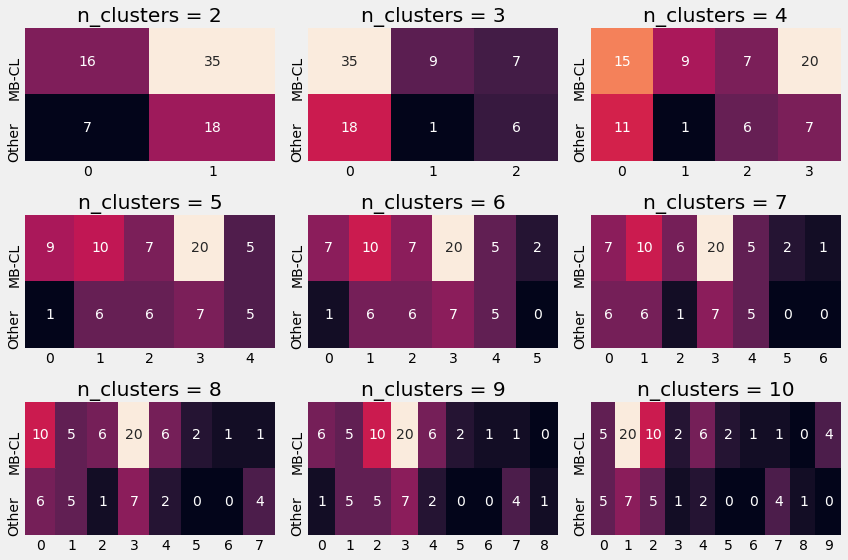

In [33]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=10
k=2
while k < 10:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="average", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_variance)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Average Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does already a poor job separating the labels in different clusters ,the cluster 1 has both more than double "MB-CL" instances than cluster 0 but also more than double "Other" instances.
> *    only with #clusters=8 do we have a 'Other' dominant cluster, capturing 4 'Other' instances in cluster 7 making up 80% of all its instances.
> *    from #clusters to #clusters we see the "MB-CL" being increasingly distributed among clusters , and the optimal result would be if all of them clustered in one cluster.
> 
> In general this metric doesn't seem optimal to handle X_variance data but the best results and the ones supported by the silhoutte scores results are achieved with #clusters=2.

#### Ward Linkage

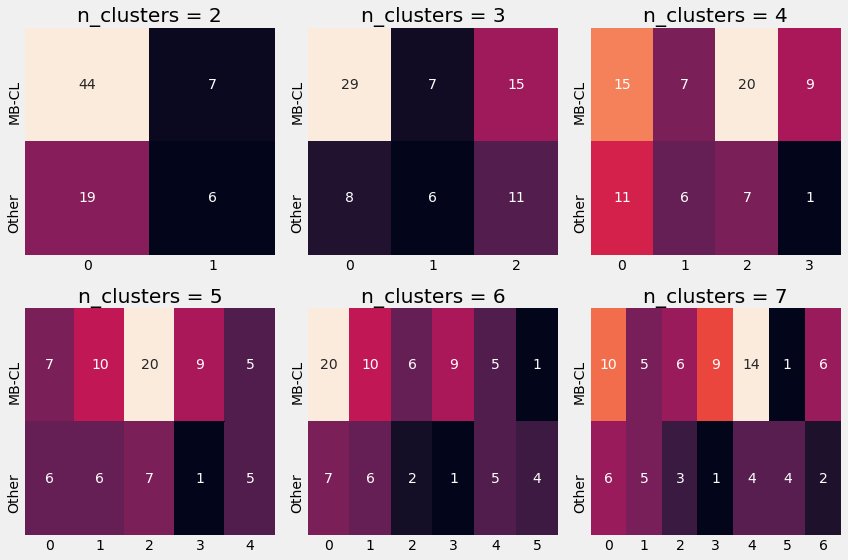

In [34]:
# defining rows and cols for the plot grid
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=7
k=2
while k < 7:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="ward", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_variance)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Ward Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does already a poor job separating the labels in different clusters ,but its a better result than when using the "average" metric. We have cluster 0 with most of the "MB-CL" instances and an almost neutral cluster 1.
> *    only with #clusters=6 do we have a 'Other' dominant cluster, capturing 4 'Other' instances in cluster 5 making up 80% of all its instances.
> *    from #clusters to #clusters we see the "MB-CL" being increasingly distributed among clusters , and the optimal result would be if all of them clustered in one cluster.
> 
> In general this metric doesn't seem optimal to handle X_variance data but seems better than the average metric, the best results and the ones supported by the silhoutte scores results are achieved with #clusters=2.

#### Complete Linkage

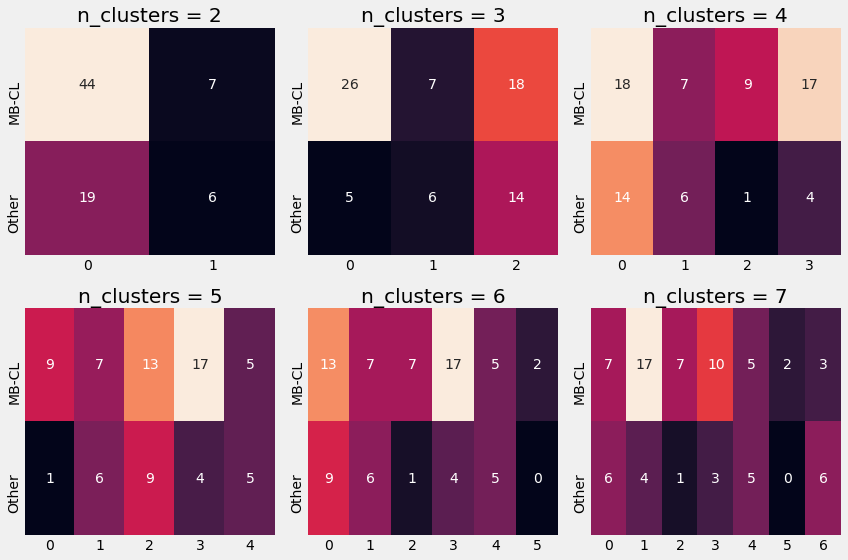

In [35]:
# defining rows and cols for the plot grid
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=7
k=2
while k < 7:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="complete", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_variance)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Complete Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does already a poor job separating the labels in different clusters ,its an equal result to when using the "ward" metric. 
> *    only with #clusters=7 do we have a 'Other' dominant cluster, capturing 6 'Other' instances in cluster 6 making up 66,6% of all its instances.
> *    from #clusters to #clusters we see the "MB-CL" being increasingly distributed among clusters , and the optimal result would be if all of them clustered in one cluster.
> 
> In general this metric doesn't seem optimal to handle X_variance data but seems better than the average metric, the best results and the ones supported by the silhoutte scores results are achieved with #clusters=2.

#### Single Linkage

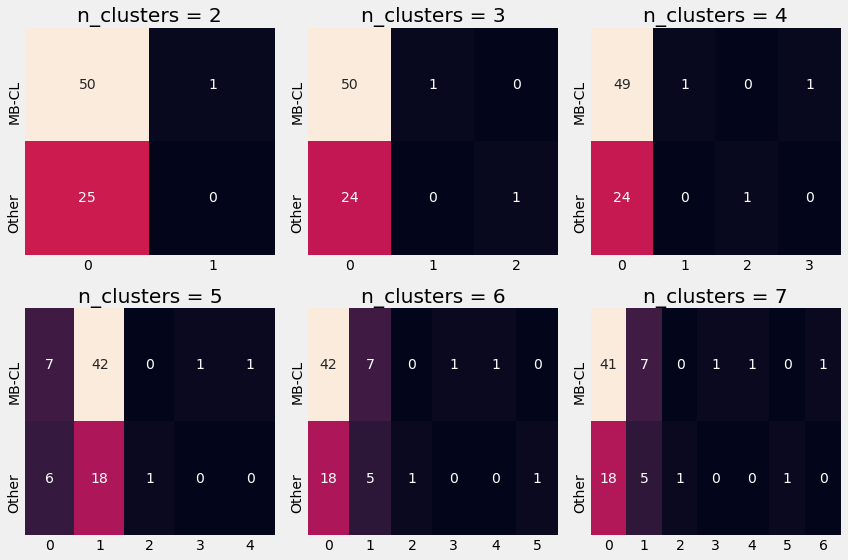

In [36]:
# defining rows and cols for the plot grid
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=7
k=2
while k < 7:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="single", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_variance)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Single Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does a somewhat good job separating the labels in different clusters with almost all "MB-CL" in one cluster.
> *    with #clusters=3 the hca algorithm constructs  a 'Other' dominant cluster with one instance, and then another with #clusters=5.
> *    from #clusters to #clusters we see the "MB-CL" being increasingly distributed among clusters , and the optimal result would be if all of them clustered in one cluster.
> 
> The best results and the ones supported by the silhoutte scores results are achieved with #clusters=2.

### Choosing the best linkage metric and nº clusters for X_variance data

> The n_Clusters ideal to deal with the X_Variance data seems to be n_Clusters=2 in every metric. 
> 
> In general, the results of the clustering using X_Variance weren't the best for any linkage metric, but the ones that showed the best results were "Complete" and "Ward" because they isolated the most "Other instances" with minimal number of clusters than any other.

## 4. Clustering using Hierarchical Clustering - X_PCA data

### Silhoutte Score for various linkage metrics -X_PCA

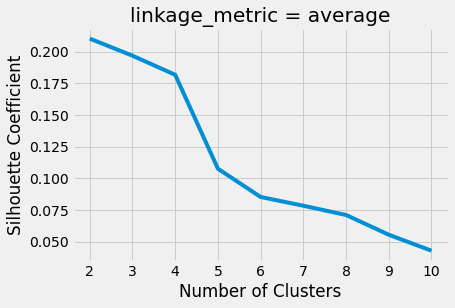

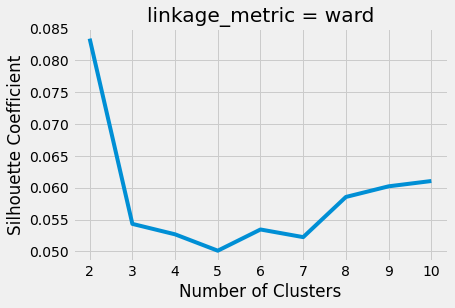

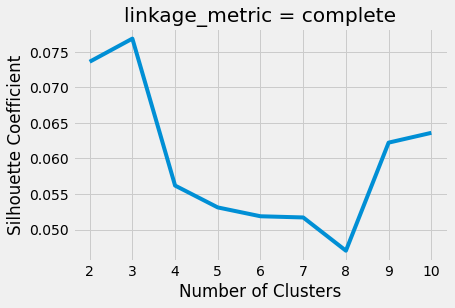

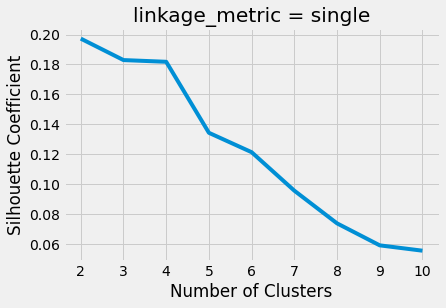

In [37]:
linkage= ["average","ward","complete","single"]#linkage metrics list
for j in linkage:
  # silhoutte score results for every linkage with n_clusters between 2 and 10
  silhouette_coefficients = []
  for i in range(2, 11):
    hca = AgglomerativeClustering(linkage =j, n_clusters=i)
    hca = hca.fit(X_PCA)
    score = silhouette_score(X_PCA, hca.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, 11), silhouette_coefficients)
  plt.title('linkage_metric = ' + str(j))
  plt.xticks(range(2, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

We analysed  Average Linkage's Silhouette scores and found that:
> The maximum coefficient is achieved by #cluster=2

We analysed  Ward Linkage's Silhouette scores and found that:
> The maximum coefficient is achieved by #cluster=2
> After that comes a sharp descent until a small rise in #cluster in [5;6] and in [7;10]
> Local maximums at #cluster=6;10

We analysed  Complete Linkage's Silhouette scores and found that:
> There is a rise in coefficients at #cluster in [2;3]
> Maximum coefficient value at #cluster=3
> There is a rise in coefficients at #cluster in [8;9]
> Local Maximum coefficient value at #cluster=9

We analysed  Single Linkage's Silhouette scores and found that:
> There is a descent in coefficients at #cluster in [2;4] and after that there is a abrupt decrease in coefficients
> Local Maximum coefficient value at #cluster=2; 4


### Contingency Matrixes per linkage metric with multiple Nºclusters

#### Average Linkage

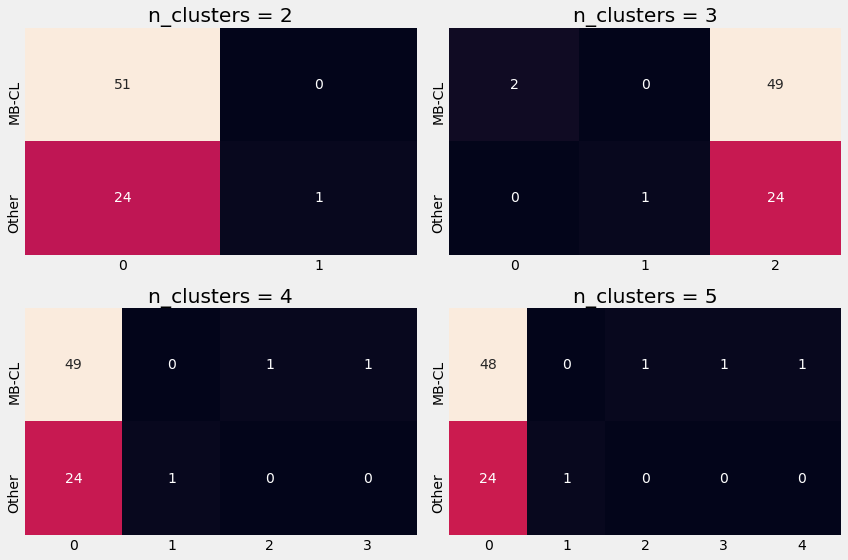

In [38]:
# defining rows and cols for the plot grid
rows=2
cols=2
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=5
k=2
while k < 6:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="average", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Average Linkage we observed that:
> 
> *   with #clusters=2 the hca algorithm captures all 51 'MB-CL' labels incluster 0 but only captures one 'Other' instance onto  cluster 1 (4% of all 'Other' labels'. This 'Other' ratio doesn't get any better in subsequent #cluster values until #cluster=6
> *   with #clusters>=3 the 51 'MB-CL' labels are distributed by the remaining (#clusters -1) clusters which is not the optimal result of having only one cluster with all instances of a label, for each label.
> 
> The best results seem to be provided by  the #clusters=2 condition, which is supported by the average linkage silhouette scores as the highest coefficient values where obtained by #clusters=2.

#### Ward Linkage

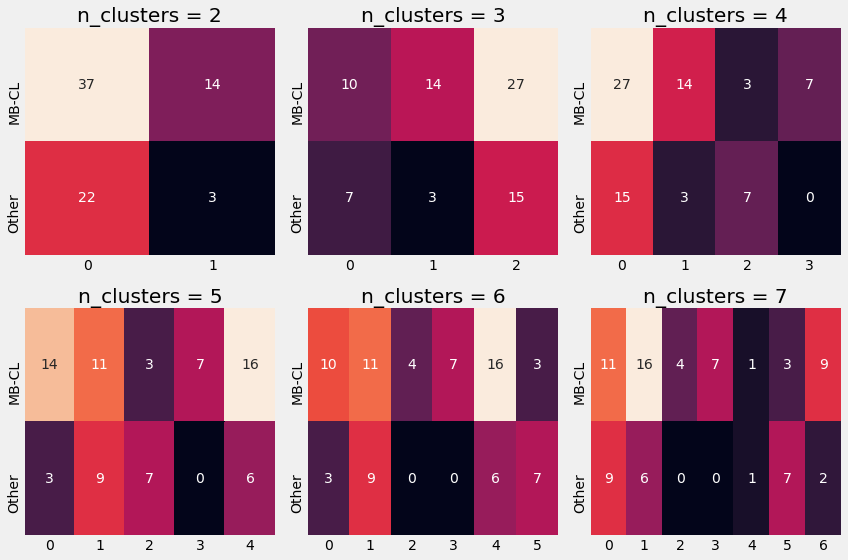

In [39]:
# defining rows and cols for the plot grid
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=7
k=2
while k < 8:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="ward", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Ward Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does already a poor job separating the labels in different clusters which is expected since this linkage metric's highest silhouette coefficient value is near 0,085 whilst in average linkage we have 0,212 has the highest value.
> *    only with #clusters=4 do we have a 'Other' dominant cluster, capturing 7 'Other' instances in cluster 2 making up 70% of all its instances
> *    with #clusters>=5 we don't see the capturing of any more 'Other' instances ,just the distribution of the remaining 'MB-CL' instances between (#clusters -1) clusters.
> 
> The best results seem to be provided by the #clusters between 2 and 4 . We continue the study with #clusters=2;4 to use both the silhouette scores best results but also what we just observed in the contingency matrixes.


#### Complete Linkage

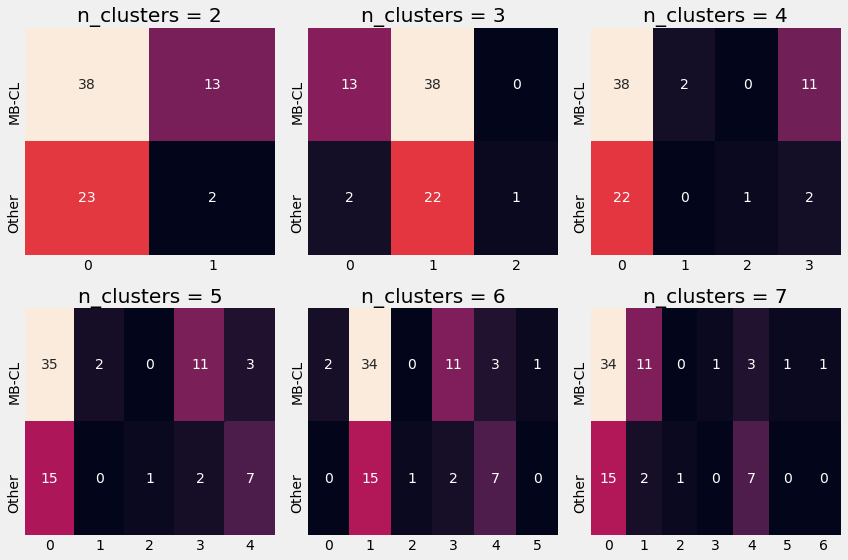

In [40]:
# defining rows and cols for the plot grid
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=7
k=2
while k < 8:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="complete", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Complete Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does already a poor job separating the labels in different clusters which is expected since this linkage metric's highest silhouette coefficient value even lower than ward linkage's.
> *    with #clusters=3 we see a 'Other' dominant cluster, capturing 1 'Other' instances in cluster 2, and with #clusters=5 there is another
> *    with #clusters>=5 we don't see the capturing of any more 'Other' dominant clusters.
> 
> The best results seem to be provided by the #clusters=3 . This result was chosen because it is supported by the silhouette scores results and the contingency matrixes.

#### Single Linkage

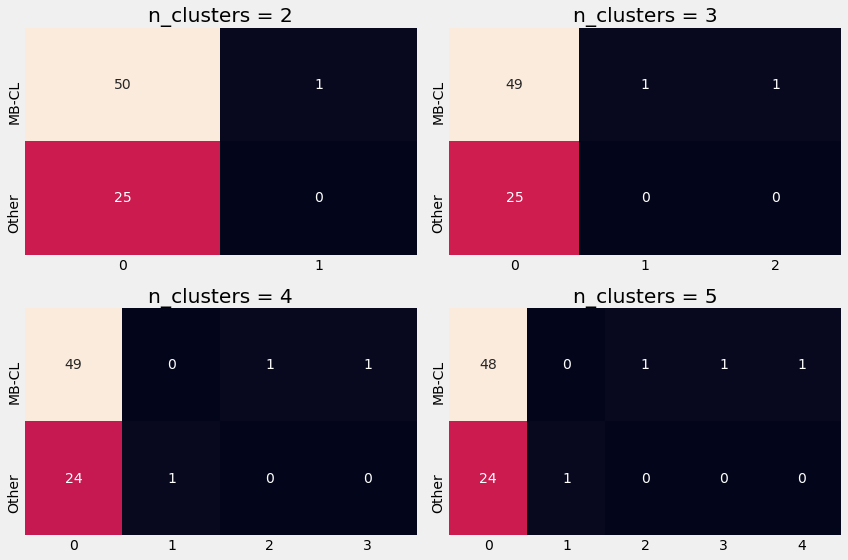

In [41]:
# defining rows and cols for the plot grid
rows=2
cols=2
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# starting at k=2 and going until k=5
k=2
while k < 6:
  for i in range(rows):
    for j in range(cols):
      # creating a hca object with n_clusters=k
      hca = AgglomerativeClustering(linkage ="single", n_clusters=k)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Analysing the resulting Contingency Matrixes of Single Linkage we observed that:
> 
> *    with #clusters=2 the hca algorithm does a poor job separating the labels in different clusters but single linkage does a better job than the ward or complete metrics, as it is seen in the silhouette scores results.
 With #clusters=2 all but one 'MB-CL' instances are captured in cluster 0 but cluster 1 doesn´t have any 'Other' instances.
> 
> *    only with #clusters=4 do we have a 'Other' dominant cluster, capturing 1 'Other' instance and for higher #clusters values the results don't get any better.
> 
> The best results seem to be provided by the #clusters between 2 and 4 . We continue the study with #clusters=2;4 which are both local maximums in the silhouette scores results are observed as optimal values in the contingency matrixes.

### Choosing the best linkage metric and nº clusters for X_PCA data

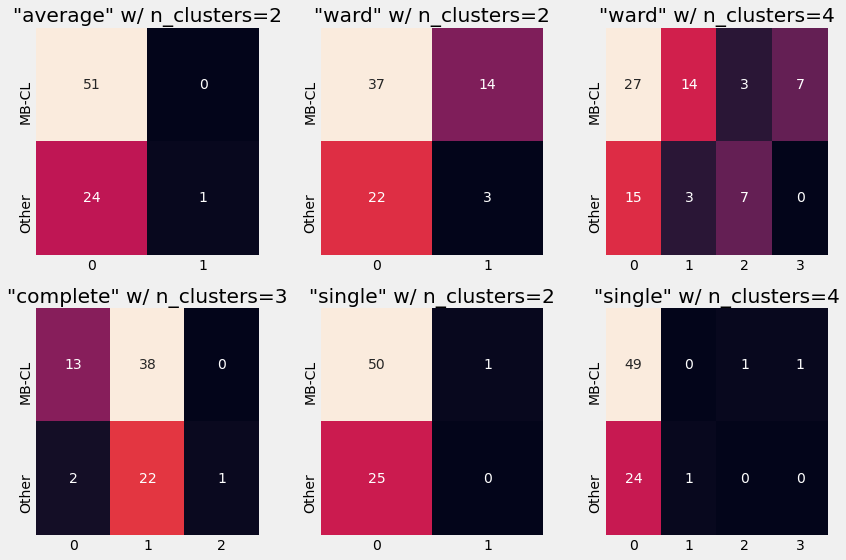

In [42]:
rows=2
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(12,8))

# best results from every linkage metric plotted together
for i in range(rows):
  for j in range(cols):
    if i==0 and j==0 :
      hca3 = AgglomerativeClustering(linkage ="average", n_clusters=2)
      # fitting the object to the data
      hca3 = hca3.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca3.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"average" w/ n_clusters=2')
    if i==0 and j==1 :
      hca = AgglomerativeClustering(linkage ="ward", n_clusters=2)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"ward" w/ n_clusters=2')
    if i==0 and j==2 :
      hca = AgglomerativeClustering(linkage ="ward", n_clusters=4)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"ward" w/ n_clusters=4')
    if i==1 and j==0 :
      hca = AgglomerativeClustering(linkage ="complete", n_clusters=3)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"complete" w/ n_clusters=3')
    if i==1 and j==1 :
      hca = AgglomerativeClustering(linkage ="single", n_clusters=2)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"single" w/ n_clusters=2')
    if i==1 and j==2 :
      hca = AgglomerativeClustering(linkage ="single", n_clusters=4)
      # fitting the object to the data
      hca = hca.fit(X_PCA)
      # creating a contingency matrix with true labels and  hca labels
      cm_X=contingency_matrix(y['class'], hca.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('"single" w/ n_clusters=4')

fig.tight_layout()
plt.show()

> Analysing the best results obtained ysing X_PCA data we conclude that:
* Results of using the "single" or "average" metrics with n_clusters=2 capture most of the "MB-CL" label instances in cluster 0. The "single" metric is a bit better though because its cluster 1 captured a "Other" instance. Both these results where better than the ones while using the "ward" metric.
* The results given by using the "ward" linkage with n_clusters=4 capture 7 "Other" instances in a "Other" dominant cluster but the "MB-CL" labels aren't properly concentrated in as few clusters as possible, and the "ward" linkage isn't overall a metric that gives good results anyway while using X_PCA data.
* The "average" metric with n_clusters=2 result has the "MB-CL" more concentrated in one unique cluster than any other result while also having 2 different label dominant clusters, while using X_PCA data these are the best HCA settings to use.

## Comparison of Results and Discussion Variance vs PCA

> Without a doubt X_PCA gave the best clustering results using any linkage metric. 
> 
> Using X_PCA gave the most "Other" dominant clusters and also higher "MB-CL" concentration in one cluster when compared with X_Variance.
> 
> The results of using hca on both X_PCA and X_Variance were sub-optimal. 
> 
> No experiment gave the optimal case of all clusters being label segregated, ideally with n_clusters=2. And the label separation observed was minimal.

## 5. Evaluating Clustering Results

In this task you should compare the best results obtained using `K`-means and HCA 
1. **Without using ground truth**
2. **Using ground truth (`Medulloblastoma Type`)**.

### 5.1. Without Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

> Calinski Harabasz (CH) metric for evaluation without prior knowledge of Ground Truth was chosen due to it's ease of calculation.
> 
> The Calinski-Harabasz score, works best on "globular" clustering algorithms, because it favours clusters in which their centrers are far apart and the cluster members are close to their respective centers.
> 
> Like most internal clustering criteria, Calinski-Harabasz is a heuristic device. The proper way to use it is to compare clustering solutions obtained on the same data, - solutions which differ either by the number of clusters or by the clustering method used.
> 
> Since there is no analysis requirements for CH, one can simply compare its results manually, the higher the value, the "better" is the apparent clustering evaluation of the cluster. If the CH line appears to peak or form an *elbow*, that's the highest confidence solution. On the contrary, if the line appears to be flat or relatively linearm then there's no specific reason to choose one choice of clustering over the others. solution give a peak or at least an abrupt elbow, choose it. If, on the contrary, the line is smooth - horizontal or ascending or descending - then there is no reason to prefer one solution to others.

> Below is the processing of data to be analyzed using the HC algorithm scorage.

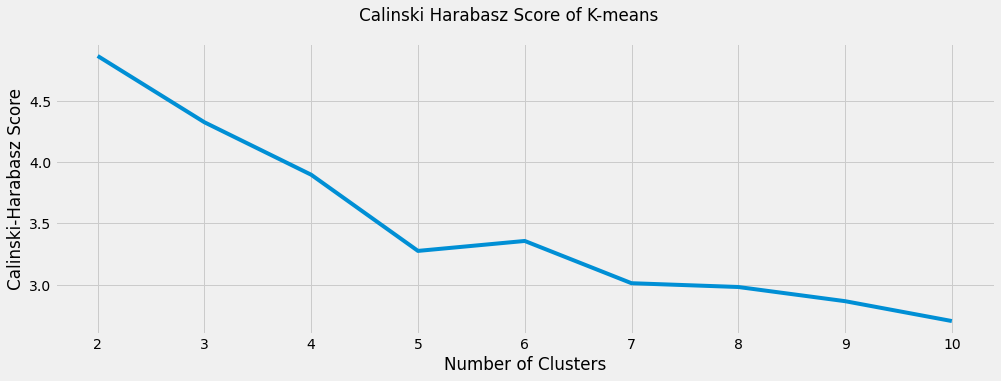

In [43]:
ch_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(std_X)
  score = calinski_harabasz_score(std_X, kmeans.labels_)
  ch_scores.append(score)

fig, ax = plt.subplots(figsize=(15,5))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), ch_scores)
plt.suptitle("Calinski Harabasz Score of K-means")

plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

> The above result of the CH score of K-means, shows that the lowe the number of clusters, the higher the CH score. However its shape is also quite smooth and linear, which indicates that the clustering confidence strength given by HC is proportional to the number of clusters. Which means there's no absolutely clear choice.
> 
> However, since there's a small peakage at nº of n_clusters={2, 3}: with values close to ~5 and 4.4, respectively; these are likely the best candidates, since at n_clusters={4,5} there's a small dip.

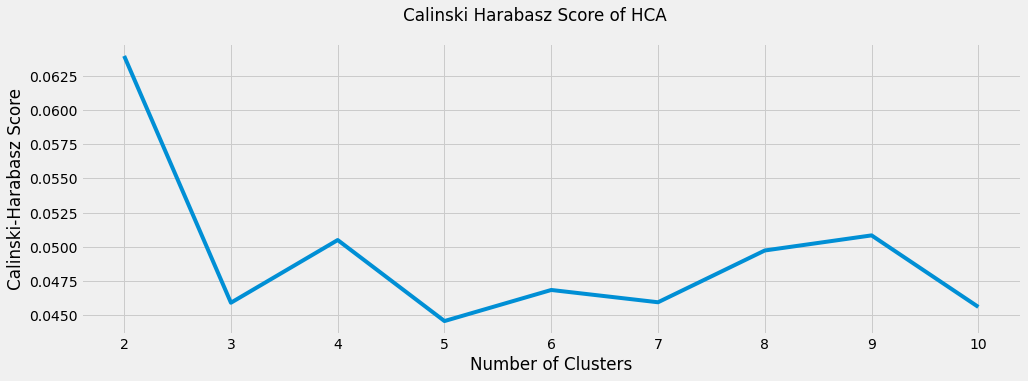

In [44]:
ch2_scores1 = []
for i in range(2, 11):
  hca1 = AgglomerativeClustering(n_clusters=i)
  hca1 = hca1.fit(std_X)
  score = silhouette_score(std_X, hca1.labels_)
  ch2_scores1.append(score)

fig, ax = plt.subplots(figsize=(15,5))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), ch2_scores1)
plt.suptitle("Calinski Harabasz Score of HCA")

plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

> In comparison to the previous, the CH score for HCA, shows much varied scores, which was expected, considering unlike K-means, the input data was supervised by the HCA algorithm.
> 
> n_clusters=2 are shown to be the one with the highest score, of around 0.0625, which is actually a very low number, considering CH ranges from {-n,0,n}, but as it can be analyzed independently and self contained, one can confirm that 2 clusters are the higher value of confidence.
> 
> *However*, as per CH description, one should choose the value that peaks and creates and *elbow* as the most likely better candidate, which in this case is shown to be n_clusters=4 with a score of ~0.05. As such, that is the one that one should choose and, therefore, ignore any further higher count clusters.


### 5.2. Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

> Silhouette score is used to evaluate how well samples are clustered with other samples that are similar to each other.

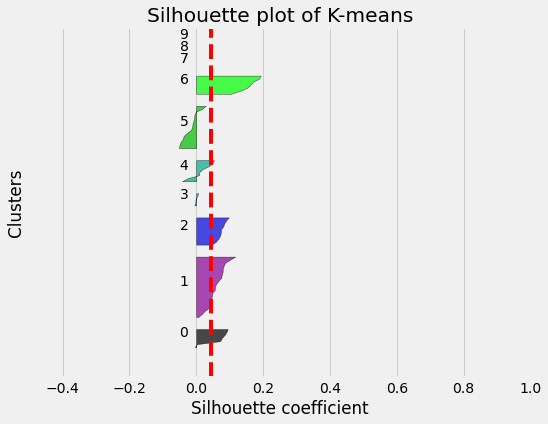

In [45]:
draw_silhouette(std_X, kmeans.labels_, "of K-means")

> The SC for K-means is low overall, considering SC outputs results on a {-1,0,1} range. Considering K-means average of 0.02, this is actually quite a low number., altough the number is biased by average by 0 and 1, which from all we can tell, is supposed to be included.
> 
> n_clusters=2 has the highest confidence with close to 0.2, *en pair* with the previous analysis without Ground Truth. Considering most other results are below the average, one can discard them altogether. Only at high n_clusters>=7 can we find scores higher than the average.

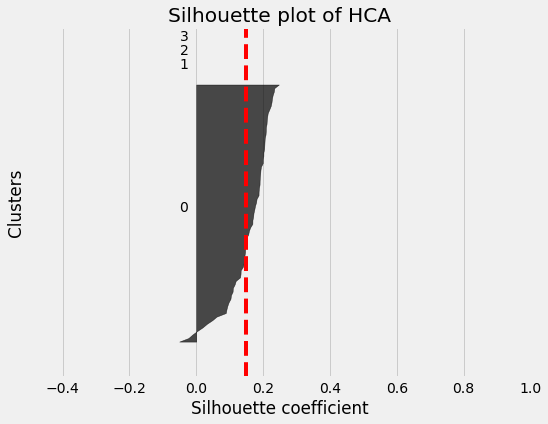

In [46]:
draw_silhouette(std_X, hca.labels_, "of HCA")

> The SC for HCA is highly mutable, with the average silhouette score being below zero, at 0.005. n_clusters=2 is again the lowest number of clusters with the highest score. However at high values starting at n_clusters>=5, the clustering score is increases exponentially. 
This is interesting, because it means that the clusters are densely and high numbers of clusters are needed to separate the close values. However this is problematic, as shown, as it most likely divides clusters into subclusters over zealously. 

> We can see that without using Ground Truth, the certainty is overall higher. Specially when considering the HCA method to identify the higher confidence n_cluster.

## 6. Clustering Samples using Density-based Clustering

Use DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) or OPTICS (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) to cluster the samples.

Compare the results with those of K-means and HCA.

> Below is the training model using OPTICS. We chose this algorithm due to its ease of use as well as straightforward preprocessing, unlike DBSCAN which has large overheard requirements. 
> 
> Besides, from our testing and accurate to the Teacher's comments, DBSCAN adds noise which may increment difficulties while analysing, even if its output was mostly close to OPTICS. As such, OPTICS proved to be a reliable method.
> 
> The way it works is that the points are ordered such that spatially close points become neighbors in the sorting.

In [47]:
optics_model = OPTICS().fit(X_PCA)

> Above is the training model, which is followed by the generation of the scatterplot.

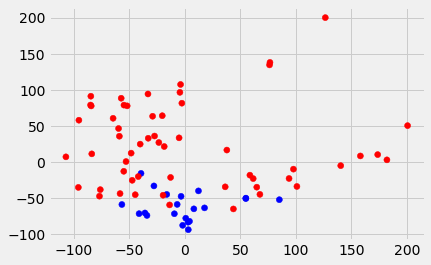

In [48]:
colors = list(map(lambda x: 'b' if x == 1 else 'r', kmeans.labels_))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=colors, marker="o", picker=True)
plt.grid(True)
plt.show()  

> The clustering results for K-means are confined to a small portion of the plot ranging from x{-10,100} and y{-60,25}, these are, therefore, the points of high reachability. The ones in red are the ones of low reachability; that is, the ones that are very densily packed together and are harder to identify as self contained clusters
> 
> Since the scattering is highly knit together, the clustering algorithm has problems dealing with such. This may be due to preprocessing problems at our end.

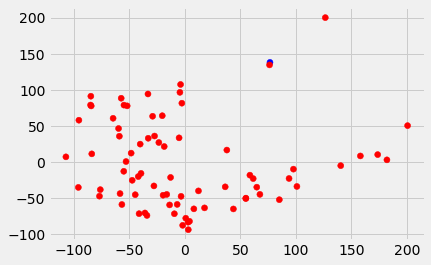

In [49]:
colors = list(map(lambda x: 'b' if x == 1 else 'r', hca.labels_))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=colors, marker="o", picker=True)
plt.grid(True)
plt.show() 

> As seen above, there's widely discrepant results between clusters, the identified clusters are at points ranging from x{-80,75} and y{-20,140}. The ones in red are the ones of low reachability; that is, the ones that are very densily packed together and are harder to identify as self contained clusters
> 
> These are the higher reachability points of HCA, as per the way OPTICS works.

> All in all, HCA labels have a higher reachability value than those of K-means, while also having better identified clustering.

## 7. Choose a Different Clustering Algorithm to Group the Samples

Choose **a clustering algorithm** besides `K`-means, HCA and DBSCAN/OPTICS to cluster the samples. 

**Groups of 3 People** must choose two different algorithms.

Justify your choice and compare the results with those of `K`-means, HCA and DBSCAN/OPTICS.

### Spectral Clustering best results (n_clusters=2)

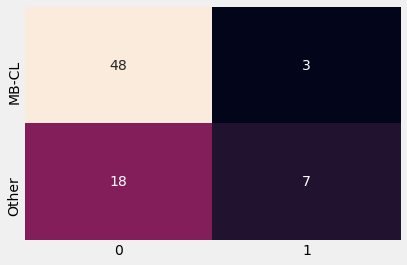

In [50]:
spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral = spectral.fit(X_PCA)# we use X_PCA because until now it gave the best results
spectral

cm_X=contingency_matrix(y['class'], spectral.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
         yticklabels=['MB-CL','Other'])
plt.show()

> Analysing the best contingency matrix for spectral Clustering we can see that it is a better result than the ones provided by HCA , and until this section the HCA provided the best results.
> 
> Almost all "MB-CL" label instances are in cluster 1 while in cluster 2 we have "Other" label dominance capturing 7 of the 25 "Other" instances.

### Mean Shift best results (estimated bandwidth)

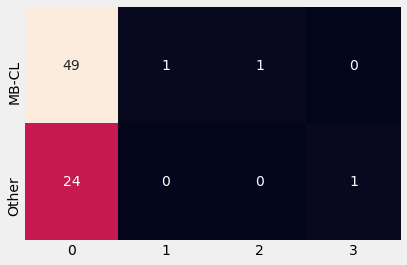

In [51]:
estimate= cluster.estimate_bandwidth(X_PCA)#estimated bandwidth
meanshift= cluster.MeanShift(bandwidth=estimate)
meanshift= meanshift.fit(X_PCA)# we use X_PCA because until now it gave the best results
cm_X=contingency_matrix(y['class'], meanshift.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
         yticklabels=['MB-CL','Other'])
plt.show()

> Analysing the best contingency matrix for Mean Shift Clustering we see that is best compared to an HCA with a "single" linkage metric, although most of the "MB-CL" instances are mostly concentrated on one cluster , there is only one instance of the "Other" label captured outside of this cluster. 
> 
> This method seems to lack the sufficient ability to separate labels and for that it is not a very good alternative in this context specially when compared to HCA and Spectral Clustering.

## 8. Conclusions

Draw some conclusions about this project work. Can you highlight some insights about meduloblastoma types? 

> Overall, we conclude that the results obtained were not the best. This might be due to 2 reasons:
>
> 1. Choices done in the preprocessing phase - defining threshold values was something we struggled with and that as a significant impact in the results we obtained.
>
> 2. The nature of the dataset and the problem. This seems to be the most important factor to consider. 
>
> The dataset was composed of genes for a labeled class of medulloblastoma ('MB-CL') and a mixed class of other types ('Other'). However, their gene expression levels are probably very close to each other that a strong separation between each type might be difficult to achieve.
>
> The mixed nature of the class 'Other' can also cause problems. Although we know that the samples do not match classic medulloblastoma, we do not know the real class to which they belong. There might be very different classes under the label 'Other' that might make it harder to group these genes in the "correct" clusters.
>
> We also know that the classification for a tumor the tumor location, tumor type, extent of tumor spread, genetic findings, the patient’s age, and tumor remaining after surgery, if surgery is possible ([source](https://www.cancer.gov/rare-brain-spine-tumor/tumors/medulloblastoma)). In the dataset that we worked with we had only access to gene expression levels, which might not be enough to correctly classify a tumor. 
>
> All of these factors might be the reason for the clustering results to be not as clear as we would want them to be.